# $\mathrm{CH_3COCH_3}$ (Acetone)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3C(O)CH3" 
nice_name = "CH_3COCH_3"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([253.7, 265.2, 280.4, 289.4, 302.5, 313.0, 334.1, 190.0, 190.02, 190.06  …  341.0, 342.0, 343.0, 344.0, 345.0, 346.0, 347.0, 348.0, 349.0, 350.0], [2.9e-20, 4.28e-20, 4.74e-20, 3.94e-20, 2.42e-20, 1.09e-20, 3.8e-21, 1.01e-17, 1.03e-17, 1.08e-17  …  6.0e-23, 5.0e-23, 4.0e-23, 3.0e-23, 3.0e-23, 2.0e-23, 2.0e-23, 2.0e-23, 2.0e-23, 2.0e-23], [298.0, 303.0, 303.0, 298.0, 296.0, 323.0, 235.0, 254.0, 263.0, 280.0  …  298.0, 296.0, 298.0, 294.0, 294.0, 296.0, 293.0, 296.0, 296.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  57, 57, 57, 57, 57, 57, 57, 57, 57, 57], "K", "Organics (carbonyls)", "CH3C(O)CH3", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

8972


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,244.315,144.25,245.75,374.559,0,Float64
2,σ,4.06285e-18,2.37372e-25,3.71e-20,1.14e-16,0,Float64
3,T,296.91,294.0,298.0,303.0,0,Float64
4,source_id,37.4939,1,46.0,57,0,Int64


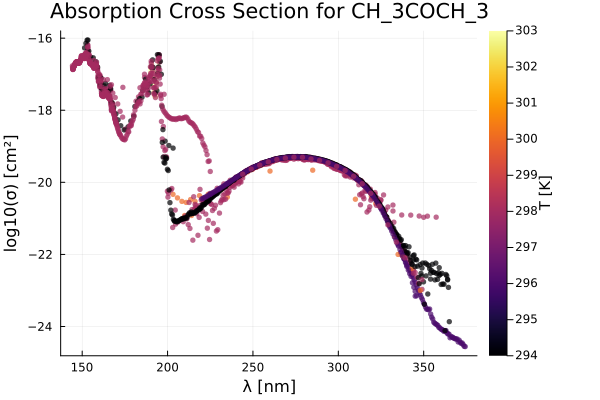

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


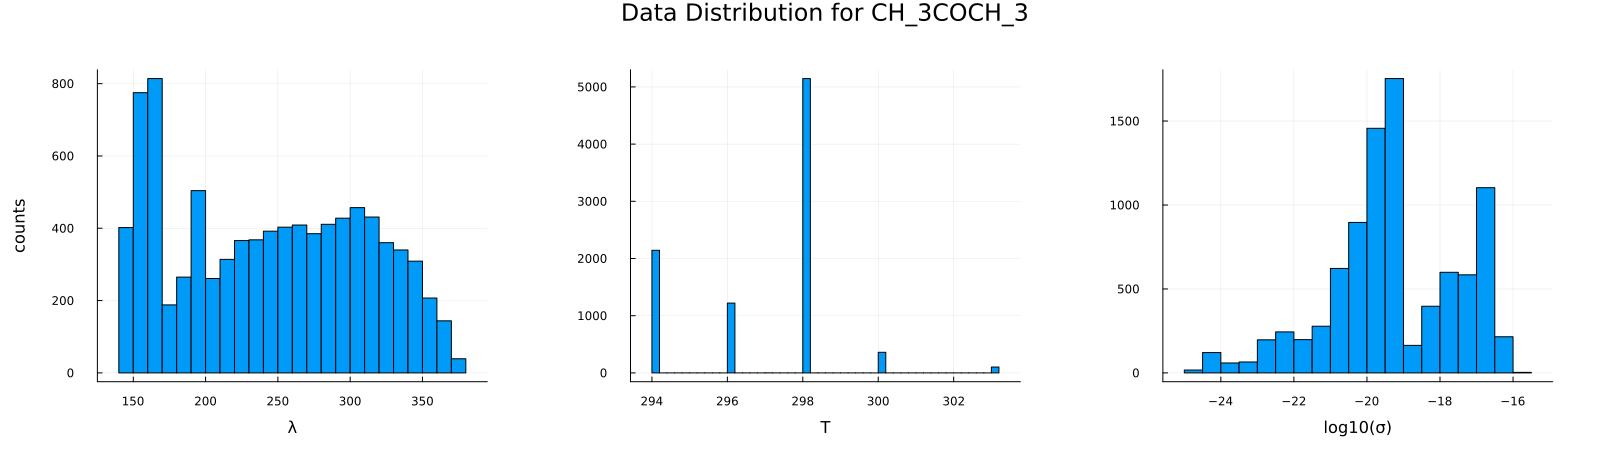

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,151.41,5.37e-17,294.0
2,151.49,5.97e-17,294.0
3,151.54,6.52e-17,294.0
4,151.73,7.16e-17,294.0
5,152.02,7.54e-17,294.0
6,152.16,7.19e-17,294.0
7,152.28,6.87e-17,294.0
8,152.55,6.72e-17,294.0
9,152.67,7.04e-17,294.0


In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

df_unique = df_unique[df_unique.T .!= 298.0, :]

7999


Row,λ,σ,T
,Float64,Float64,Float64
1,151.41,5.37e-17,294.0
2,151.49,5.97e-17,294.0
3,151.54,6.52e-17,294.0
4,151.73,7.16e-17,294.0
5,152.02,7.54e-17,294.0
6,152.16,7.19e-17,294.0
7,152.28,6.87e-17,294.0
8,152.55,6.72e-17,294.0
9,152.67,7.04e-17,294.0


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(2511, 3)


151.41

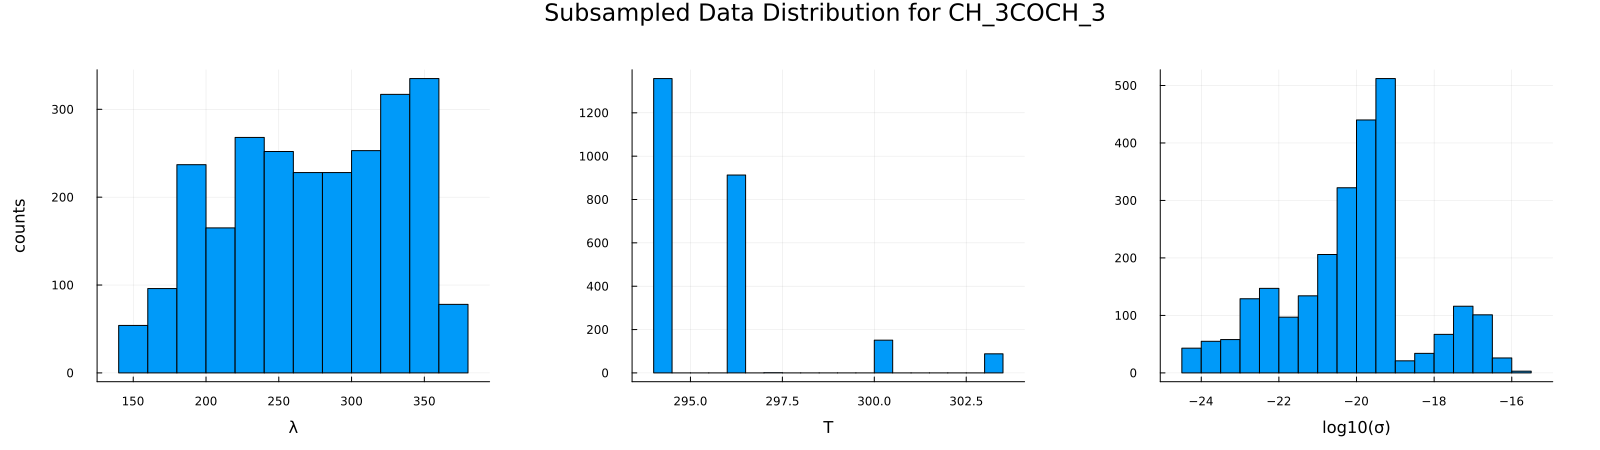

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

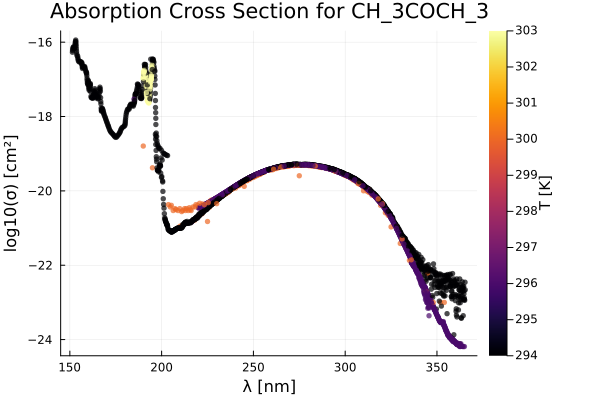

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [17]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

2259


In [18]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

252-element Vector{Float64}:
 -19.291409154849656
 -19.320618588105024
 -21.088178306130413
 -20.08453562170915
 -18.123782159408357
 -22.038794573631947
 -21.05928434309334
 -20.01480126011916
 -23.0
 -19.81191562628506
 -17.35556141053216
 -21.099469017547243
 -21.451119437362486
   ⋮
 -20.558830828260252
 -19.42354346759438
 -20.311817689880236
 -20.99783393824349
 -20.098378235906644
 -16.946921556516582
 -16.66554624884907
 -22.443818153347088
 -23.885295629146263
 -16.7594507517174
 -19.69486368105636
 -16.145086977692145

In [19]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [20]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.0854154142921058, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.080722221782053, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.7351322673448617, exp, 1.4901161193847656e-8)), 
  σ² = 0.11842677930508728, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [21]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     1.820332e+03     8.332384e+02
 * time: 0.017065048217773438
     1     1.397572e+03     7.571016e+02
 * time: 14.47877812385559
     2     3.429091e+02     8.087107e+02
 * time: 21.35470199584961
     3    -1.098272e+02     5.733413e+02
 * time: 23.89146614074707
     4    -3.943190e+02     1.735805e+02
 * time: 26.336263179779053
     5    -4.488984e+02     1.345197e+02
 * time: 28.754916191101074
     6    -4.788904e+02     9.939501e+01
 * time: 31.423205137252808
     7    -4.991896e+02     1.000866e+02
 * time: 35.30382513999939
     8    -5.219306e+02     4.315518e+01
 * time: 39.21294713020325
     9    -5.242462e+02     2.562768e+01
 * time: 41.68606519699097
    10    -5.246598e+02     4.997752e+00
 * time: 44.14106106758118
    11    -5.247513e+02     6.553438e+00
 * time: 47.81393599510193
    12    -5.249671e+02     1.633792e+00
 * time: 51.44991898536682
    13    -5.249686e+02     8.143173e-03
 * time: 55.43804097175598
 

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @973 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @055 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [22]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.039356213703152, 2.2640293579143522, 2.131278746207313, -3.5677205777063947],
 minimum = -524.9686191105229,
 iterations = 348,
 converged = false,)

In [23]:
fp = fitted_params(mach)

(θ_best = [:σf² => 56.78977057319096, :ℓ_λ => 9.621780776636966, :ℓ_T => 8.425634188255843],
 σ² = 0.02822012086325745,)

In [24]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


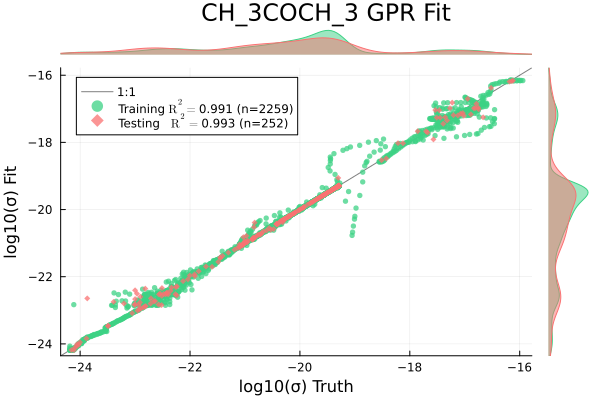

In [25]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


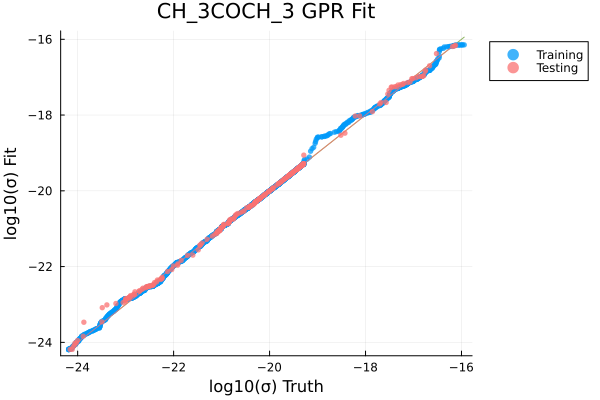

In [26]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


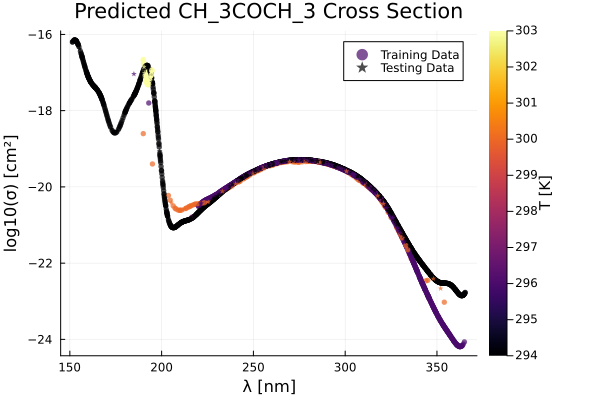

In [27]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

194.249
365.4


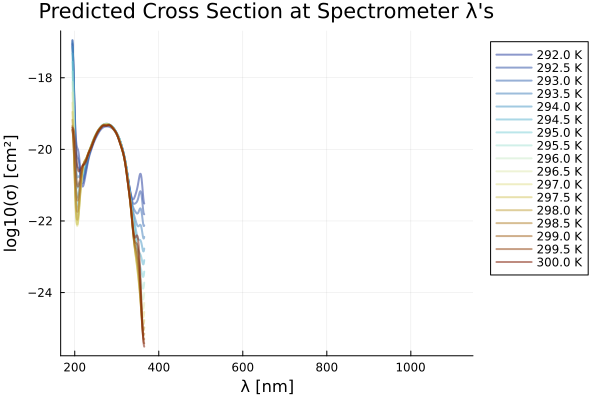

In [28]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

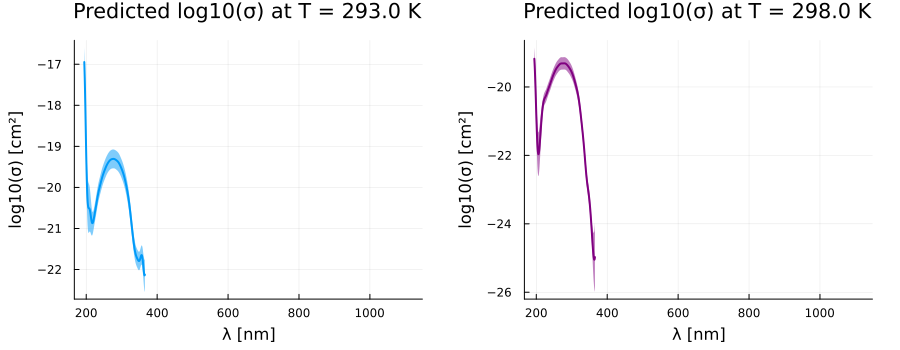

In [29]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 293.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [30]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [31]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

151.41	194.249
365.4	1120.216


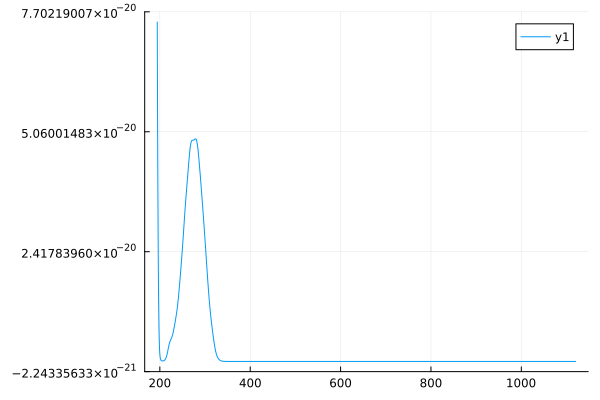

In [32]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [33]:
df_photolysis_σ.σ_21 = σ

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [34]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"